In [202]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.tsa.vector_ar.vecm import coint_johansen

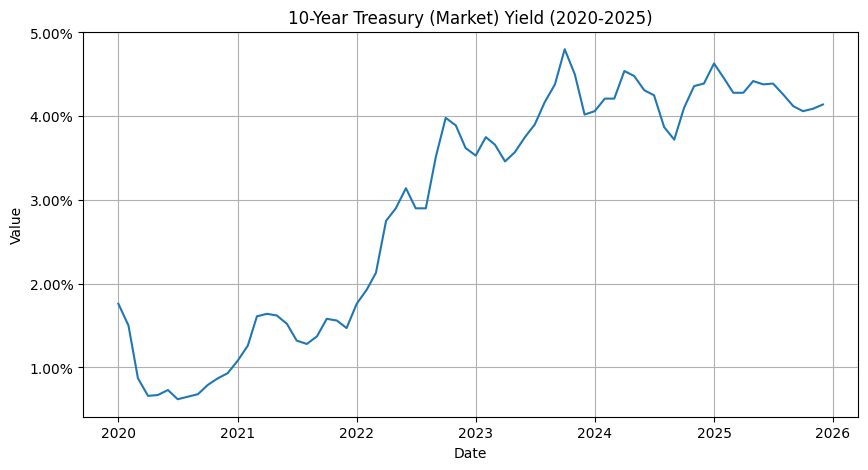

In [203]:
df = web.get_data_fred(['GS10', 'FEDFUNDS', 'T10YIE'], start='2020-01-01', end='2025-12-31').resample('MS').mean().dropna()

def plot_perc_data(data, title, yaxis):
    plt.figure(figsize=(10, yaxis))
    plt.plot(data.index, data.values)
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter()) #get ("current axis") y-axis in percentage format
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

plot_perc_data(df[['GS10']], '10-Year Treasury (Market) Yield (2020-2025)', 5)

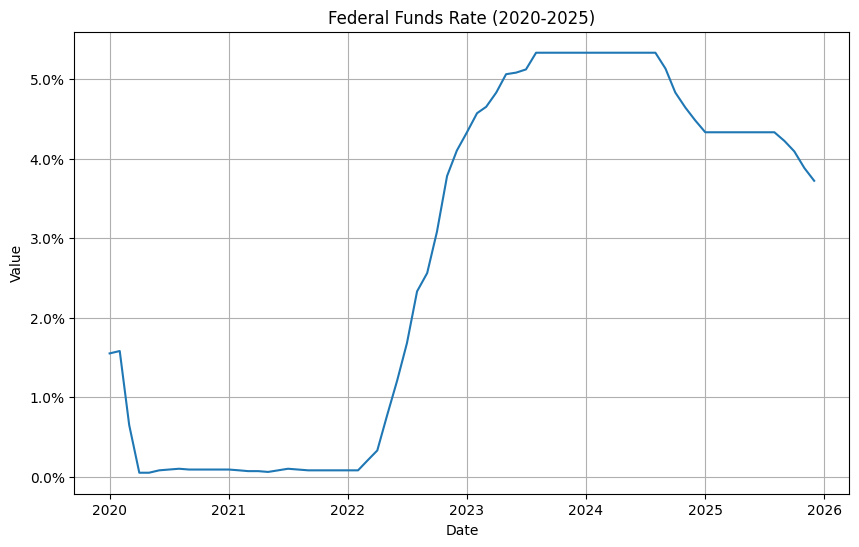

In [204]:
plot_perc_data(df[['FEDFUNDS']], 'Federal Funds Rate (2020-2025)', 6)

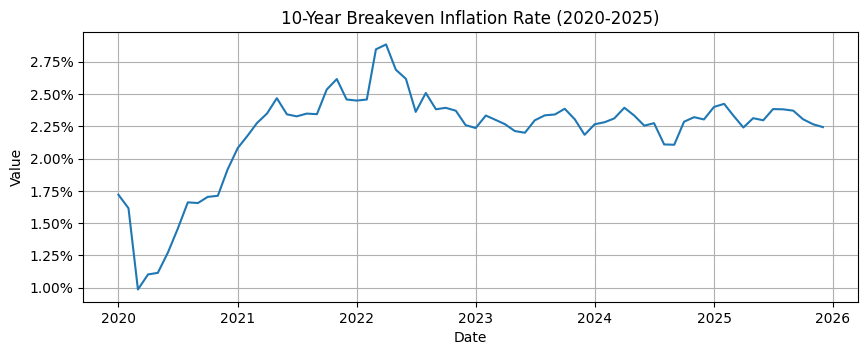

In [205]:
plot_perc_data(df[['T10YIE']], '10-Year Breakeven Inflation Rate (2020-2025)', 3.5)

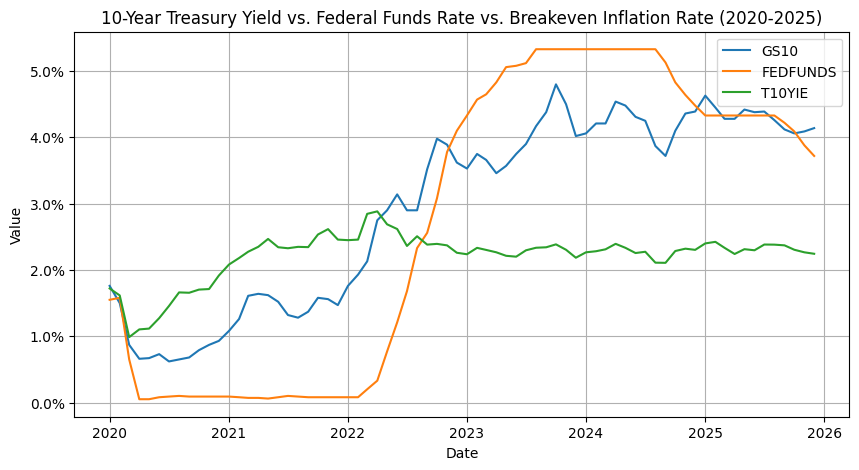

In [206]:
def plot_overlap_perc_data(data1, data2, data3, title, yaxis):
    plt.figure(figsize=(10, yaxis))
    plt.plot(data1.index, data1.values) #plot overlap
    plt.plot(data2.index, data2.values)
    plt.plot(data3.index, data3.values)
    plt.legend([f'{data1.columns[0]}', f'{data2.columns[0]}', f'{data3.columns[0]}'])
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

plot_overlap_perc_data(df[['GS10']], df[['FEDFUNDS']], df[['T10YIE']], '10-Year Treasury Yield vs. Federal Funds Rate vs. Breakeven Inflation Rate (2020-2025)', 5)

In [207]:

df_diff = df[['GS10', 'FEDFUNDS', 'T10YIE']].diff().dropna()

def adf_report(series, name, level="Level"):
    result = adf(series)
    pval = result[1]
    print(f"ADF P-Val ({level}): {pval:.4f}")
    
    # Determine stationarity
    if pval < 0.05:
        print(f"The {name} series is stationary ({level}).")
    else:
        print(f"The {name} series is non-stationary ({level}).")
    print(f"ADF Statistic: {result[0]:.4f}")

adf_report(df['GS10'], '10-Year Treasury Yield', 'Level')
adf_report(df_diff['GS10'], '10-Year Treasury Yield', '1st Difference')


coint_johansen_result = coint_johansen(df[['GS10', 'FEDFUNDS', 'T10YIE']], det_order=0, k_ar_diff=1)
print(f"\nTrace statistics: {coint_johansen_result.lr1}")
print(f"Trace critical values (90%, 95%, 99%): \n{coint_johansen_result.cvt}")
print(f"\nMax-eigenvalue statistics: {coint_johansen_result.lr2}")
print(f"Max-eigenvalue critical values: \n{coint_johansen_result.cvm}")
print(f"\nEigenvalues: {coint_johansen_result.eig}")

ADF P-Val (Level): 0.6371
The 10-Year Treasury Yield series is non-stationary (Level).
ADF Statistic: -1.2825
ADF P-Val (1st Difference): 0.0000
The 10-Year Treasury Yield series is stationary (1st Difference).
ADF Statistic: -6.8589

Trace statistics: [20.23721905  8.50834584  1.80529001]
Trace critical values (90%, 95%, 99%): 
[[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Max-eigenvalue statistics: [11.72887321  6.70305584  1.80529001]
Max-eigenvalue critical values: 
[[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]

Eigenvalues: [0.15427018 0.09131605 0.02546014]


In [208]:
model = VAR(df_diff)
results = model.fit(maxlags=12, ic='aic')
print(results.summary())

# Get the number of lags actually used
k_ar = results.k_ar
print(f"Number of lags used: {k_ar}")
print(f"Endog shape: {results.endog.shape}")
print(f"Fittedvalues shape: {results.fittedvalues.shape}")

# No r-squared in VAR for whatever reason, so we calculate it manually
for i, eq_name in enumerate(results.names):
    y_actual_trimmed = results.endog[k_ar:, i]  # starts after the initial lags

    # Get fitted values
    y_fitted = results.fittedvalues.iloc[:, i].values
    # Both arrays should have the same length (hopefully)

    assert len(y_actual_trimmed) == len(y_fitted), "Length mismatch present!"
    
    ss_res = np.sum((y_actual_trimmed - y_fitted) ** 2)
    ss_tot = np.sum((y_actual_trimmed - np.mean(y_actual_trimmed)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan
    
    print(f"R-squared for {eq_name} equation: {r_squared:.4f}")

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Jan, 2026
Time:                     21:17:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.0862
Nobs:                     67.0000    HQIC:                  -11.8617
Log likelihood:           168.173    FPE:                4.30994e-06
AIC:                     -12.3695    Det(Omega_mle):     2.53178e-06
--------------------------------------------------------------------
Results for equation GS10
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.041833         0.028380            1.474           0.140
L1.GS10             0.360875         0.150719            2.394           0.017
L1.FEDFUNDS         0.085409         0.256422            0.333       

In [209]:
# Residual serial correlation
print(results.test_whiteness(nlags=10))
if results.test_whiteness(nlags=10).pvalue < 0.05:
    print("Residuals exhibit serial correlation.\n")
else:
    print("Residuals do not exhibit serial correlation.\n")

# Stability
print(f"Model stable:", results.is_stable(), "\n")

# Granger causality (does FEDFUNDS Granger-cause GS10?)
# first time using GC test so grain of salt
print(results.test_causality('GS10', ['FEDFUNDS'], kind='f'))
print(results.test_causality('T10YIE', ['FEDFUNDS'], kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 79.659, critical value: 72.153>, p-value: 0.013>
Residuals exhibit serial correlation.

Model stable: True 

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: FEDFUNDS does not Granger-cause GS10: fail to reject at 5% significance level. Test statistic: 0.349, critical value: 2.427>, p-value: 0.845>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: FEDFUNDS does not Granger-cause T10YIE: fail to reject at 5% significance level. Test statistic: 1.606, critical value: 2.427>, p-value: 0.175>


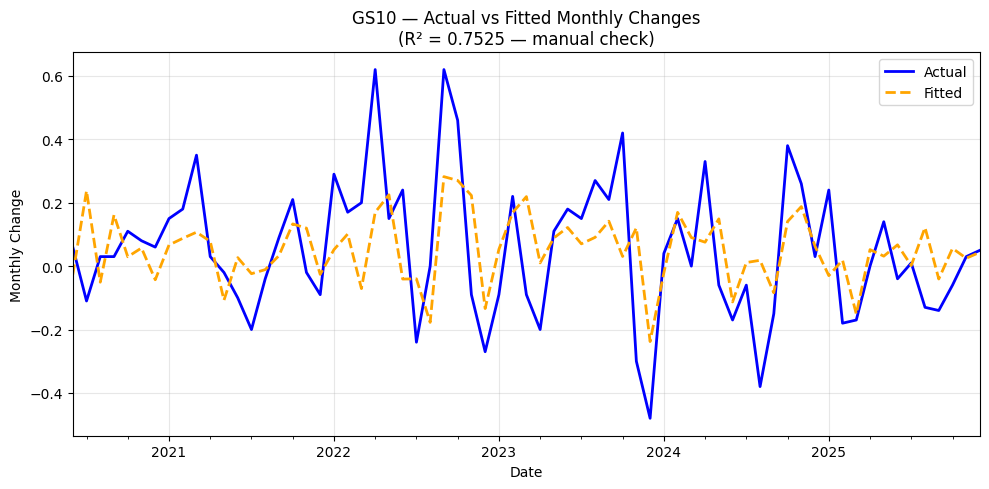

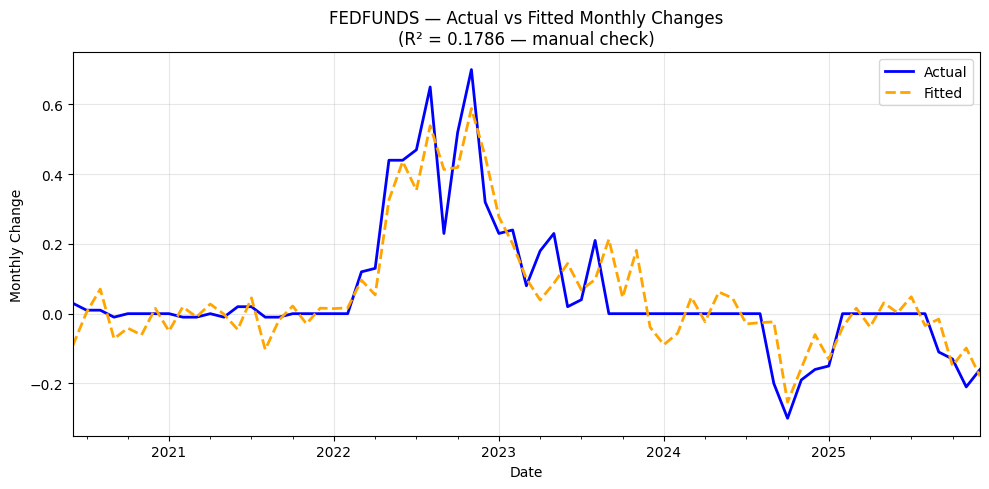

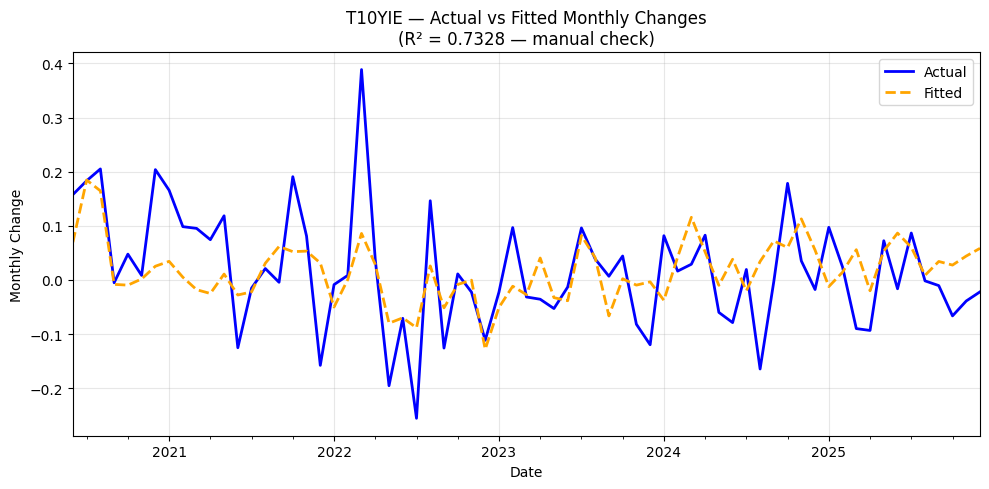

In [ ]:
forecast_diff = results.forecast(df_diff.values[-results.k_ar:], steps=12)
forecast_df = pd.DataFrame(forecast_diff, columns=results.names, index=pd.date_range(start=df_diff.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='MS'))

for i, name in enumerate(results.names): #iterates through each data series
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Actual (re-trimmed to match fitted period)
    actual_series = pd.Series(
                    results.endog[results.k_ar:, i],
                    index=df_diff.index[results.k_ar:],
                    name=f'Actual Δ{name}')
    
    # Fitted (already a Series with index)
    fitted_series = results.fittedvalues.iloc[:, i]
    
    # Plotting both
    actual_series.plot(ax=ax, label='Actual', color='blue', linewidth=2)
    fitted_series.plot(ax=ax, label='Fitted', color='orange', linestyle='--', linewidth=2)
    
    ax.set_title(f'{name} — Actual vs Fitted Monthly Changes\n(R² = {actual_series.sub(fitted_series).pow(2).sum() / actual_series.sub(actual_series.mean()).pow(2).sum():.4f} — manual check)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Monthly Change')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

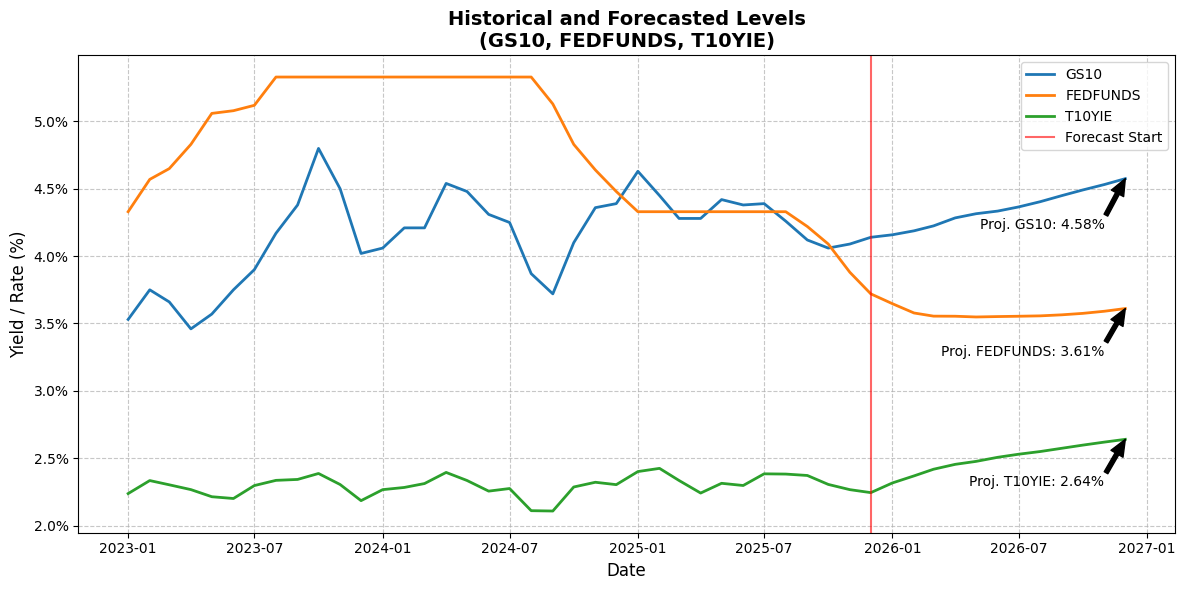

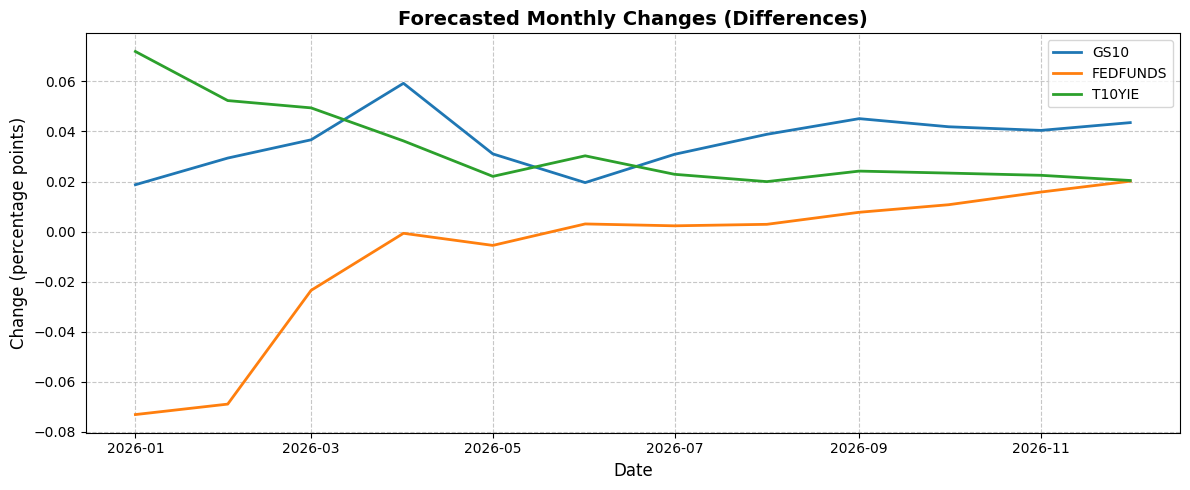

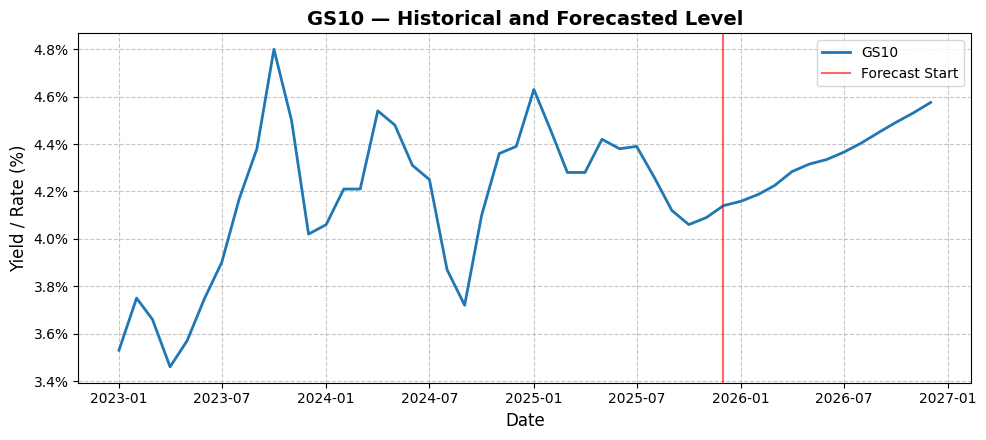

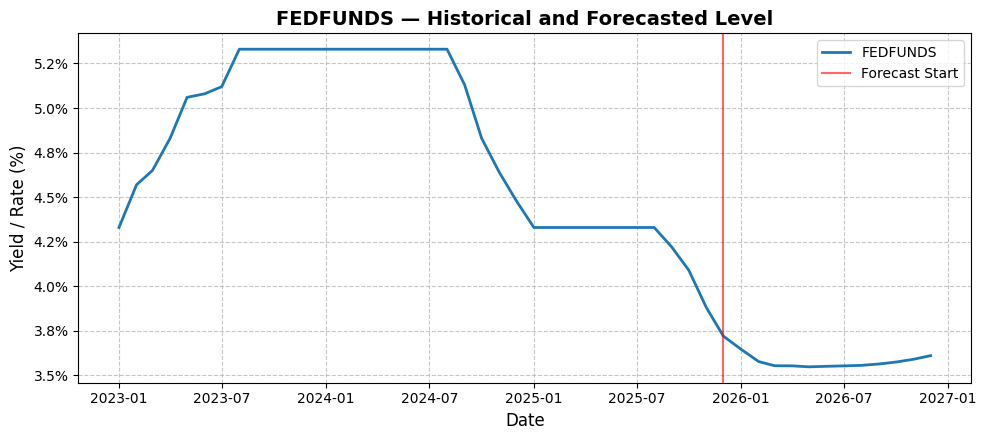

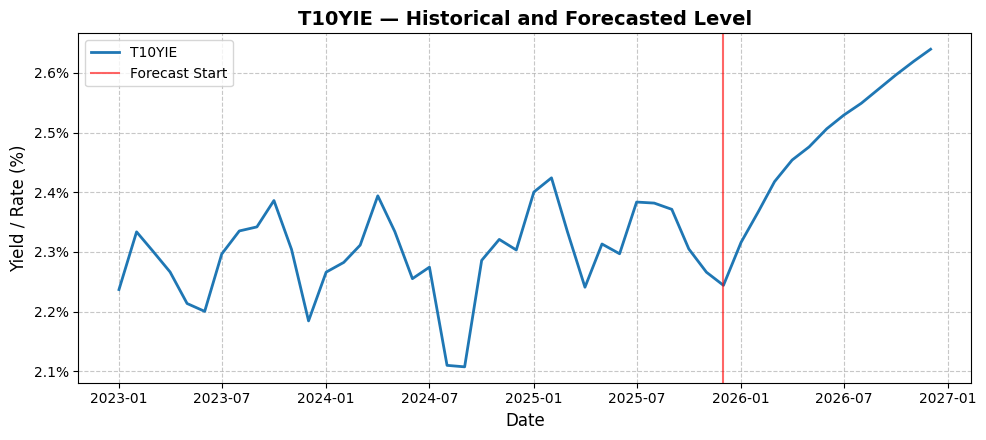

In [211]:
# swapped with block above
last_levels = df.iloc[-1][results.names]
forecast_changes = forecast_df
forecast_levels = forecast_changes.cumsum(axis=0) + last_levels

hist_window = 36
hist_levels = df[results.names].tail(hist_window)

full_levels = pd.concat([hist_levels, forecast_levels])

def plot_series(df, title, ylabel, is_percent = True, figsize=(12,6),
                show_split_line=True, annotations=False, fill_alpha=0.15,
                lower=None, upper=None):
                
                fig, ax = plt.subplots(figsize=figsize)

                for col in df.columns:
                    ax.plot(df.index, df[col], label=col, linewidth=2)

                if lower is not None and upper is not None:
                    for col in df.columns:
                        ax.fill_between(df.index, lower[col], upper[col],
                                        color='gray', alpha=fill_alpha,
                                        label=f'{col} 95% CI' if col == df.columns[0] else None)

                if is_percent:
                        ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=1))

                ax.set_title(title, fontsize=14, fontweight='bold')
                ax.set_xlabel('Date', fontsize=12)
                ax.set_ylabel(ylabel, fontsize=12)
                ax.legend(loc='best', frameon=True, fontsize=10)
                ax.grid(True, linestyle='--', alpha=0.7)
                ax.tick_params(axis='both', which='major', labelsize=10)

                # Vert line at forecast start
                if show_split_line:
                    split_date = hist_levels.index[-1]
                    ax.axvline(x=split_date, color='red', linestyle='-', alpha=0.6, linewidth=1.5, label='Forecast Start')
                    ax.legend()
                
                if annotations:
                    annotate_latest_point(ax, forecast_levels["GS10"]) #defined in block below
                    annotate_latest_point(ax, forecast_levels["FEDFUNDS"])
                    annotate_latest_point(ax, forecast_levels["T10YIE"])
                
                plt.tight_layout()
                plt.show()

def annotate_latest_point(ax, series, label_offset=-0.3): #annotate latest forecast point
    ax.annotate(f"Proj. {series.name}: {series.iloc[-1]:.2f}%",
                xy=(series.index[-1], series.iloc[-1]),
                xytext=(series.index[-2], series.iloc[-2] + label_offset),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                horizontalalignment='right',
                verticalalignment='center'
                )

# Plot 1: Historical + Forecast Levels
plot_series(full_levels, 
            'Historical and Forecasted Levels\n(GS10, FEDFUNDS, T10YIE)',
            'Yield / Rate (%)',
            is_percent=True, show_split_line=True, annotations=True)

# Plot 2: Forecast Changes Only (differences)
plot_series(forecast_df, 
            'Forecasted Monthly Changes (Differences)',
            'Change (percentage points)',
            is_percent=False, figsize=(12, 5), show_split_line=False)


#Separate plots per set
for var in results.names:
    plot_series(pd.DataFrame(full_levels[var], columns=[var]),
                f'{var} — Historical and Forecasted Level',
                'Yield / Rate (%)',
                is_percent=True, figsize=(10, 4.5), show_split_line=True)

In [212]:
print("Last observed levels (EOY 2025):")
print(df.tail(1)[results.names])

print("\nForecasted levels at 12 months ahead:")
print(forecast_levels.tail(3))

#quick summary
final_proj = forecast_levels.iloc[-1]
change_12m = final_proj - df.iloc[-1][results.names]
print("\nProjected 12-month change:")
print(change_12m)

Last observed levels (EOY 2025):
            GS10  FEDFUNDS    T10YIE
DATE                                
2025-12-01  4.14      3.72  2.244091

Forecasted levels at 12 months ahead:
                GS10  FEDFUNDS    T10YIE
2026-10-01  4.491459  3.575123  2.596844
2026-11-01  4.531892  3.590929  2.619337
2026-12-01  4.575437  3.611076  2.639760

Projected 12-month change:
GS10        0.435437
FEDFUNDS   -0.108924
T10YIE      0.395669
dtype: float64
